In [1]:
#import necessary libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from sklearn.model_selection import train_test_split

## Step 1 --- Fetch Data From Binance

In [2]:

def fetch_binance(symbol="BTCUSDT", interval="1d", limit=1000):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol,"interval": interval,"limit": limit}
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Naming the 12 binance columns 
    df.columns = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_volume", "trades","taker_base", "taker_quote", "ignore"]

    return df


In [3]:
data=fetch_binance("BTCUSDT","1d",1000)
data.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_base,taker_quote,ignore
0,1677888000000,22354.34000000,22410.00000000,22157.08000000,22346.57000000,121257.38132000,1677974399999,2706422995.68025610,4169260,60043.33153000,1340204531.15407010,0
1,1677974400000,22346.57000000,22662.09000000,22189.22000000,22430.24000000,154841.75786000,1678060799999,3473011455.18795160,4835978,77394.35765000,1735989090.89956100,0
2,1678060800000,22430.24000000,22602.19000000,22258.00000000,22410.00000000,203751.82957000,1678147199999,4569102169.18569090,6471278,102110.26304000,2289889200.16671640,0
3,1678147200000,22409.41000000,22557.91000000,21927.00000000,22197.96000000,292519.80912000,1678233599999,6517594938.24605280,7813394,145498.64219000,3242136502.65467320,0
4,1678233600000,22198.56000000,22287.00000000,21580.00000000,21705.44000000,301460.57272000,1678319999999,6641171704.24242130,8018963,150008.02488000,3304860256.10499370,0


## Step 2 --- Data Cleaning & Basic Processing

In [4]:
# Converting numeric columns to float
data[["open", "high", "low", "close", "volume"]] = data[["open", "high", "low", "close", "volume"]].astype(float)
    
# Converting timestamps to readable dates
data["open_time"] = pd.to_datetime(data["open_time"], unit="ms")
data["close_time"] = pd.to_datetime(data["close_time"], unit="ms")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   open_time     1000 non-null   datetime64[ns]
 1   open          1000 non-null   float64       
 2   high          1000 non-null   float64       
 3   low           1000 non-null   float64       
 4   close         1000 non-null   float64       
 5   volume        1000 non-null   float64       
 6   close_time    1000 non-null   datetime64[ns]
 7   quote_volume  1000 non-null   object        
 8   trades        1000 non-null   int64         
 9   taker_base    1000 non-null   object        
 10  taker_quote   1000 non-null   object        
 11  ignore        1000 non-null   object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(4)
memory usage: 93.9+ KB


## Step 3 --- Feature Engineering
- 1. Returns

In [6]:
# To ensure Close column is numeric
data["close"] = pd.to_numeric(data["close"], errors="coerce")

# 1. 1-day return
data["1d_return"] = data["close"].pct_change()

# 2. 7-day return
data["7d_return"] = data["close"].pct_change(7)

# 3. Rolling volatility (30-day rolling window)
data["rolling_volatility"] = data["1d_return"].rolling(window=30).std() * np.sqrt(365)

data.head(10)


,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_base,taker_quote,ignore,1d_return,7d_return,rolling_volatility
0,2023-03-04,22354.34,22410.00,22157.08,22346.57,121257.38132,2023-03-04 23:59:59.999,2706422995.68025610,4169260,60043.33153000,1340204531.15407010,0,NaN,NaN,NaN
1,2023-03-05,22346.57,22662.09,22189.22,22430.24,154841.75786,2023-03-05 23:59:59.999,3473011455.18795160,4835978,77394.35765000,1735989090.89956100,0,0.003744,NaN,NaN
2,2023-03-06,22430.24,22602.19,22258.00,22410.00,203751.82957,2023-03-06 23:59:59.999,4569102169.18569090,6471278,102110.26304000,2289889200.16671640,0,-0.000902,NaN,NaN
3,2023-03-07,22409.41,22557.91,21927.00,22197.96,292519.80912,2023-03-07 23:59:59.999,6517594938.24605280,7813394,145498.64219000,3242136502.65467320,0,-0.009462,NaN,NaN
4,2023-03-08,22198.56,22287.00,21580.00,21705.44,301460.57272,2023-03-08 23:59:59.999,6641171704.24242130,8018963,150008.02488000,3304860256.10499370,0,-0.022188,NaN,NaN
5,2023-03-09,21704.37,21834.99,20042.72,20362.22,443658.28584,2023-03-09 23:59:59.999,9403028764.70777380,10076702,217900.59621000,4619803522.04323720,0,-0.061884,NaN,NaN
6,2023-03-10,20362.21,20367.78,19549.09,20150.69,618456.46710,2023-03-10 23:59:59.999,12344992788.91249570,12106261,308155.80993000,6151475123.53551420,0,-0.010388,NaN,NaN
7,2023-03-11,20150.69,20686.51,19765.03,20455.73,427831.82133,2023-03-11 23:59:59.999,8651590672.46852580,10412300,213151.47855000,4310534195.90929190,0,0.015138,-0.084614,NaN
8,2023-03-12,20455.73,22150.00,20270.60,21997.11,430944.94288,2023-03-12 23:59:59.999,8982418413.80113910,9721933,218639.06880000,4558127964.92580440,0,0.075352,-0.019310,NaN
9,2023-03-13,21998.05,24500.00,21813.88,24113.48,687889.31259,2023-03-13 23:59:59.999,15824996078.60563840,14820760,346688.17025000,7976620081.70609870,0,0.096211,0.076014,NaN


- 2. Technical Indicators

In [7]:

def compute_indicators(df, close_col="close", high_col="high", low_col="low", volume_col=None):
    """
    Adds common technical indicators to a copy of df and returns it.
    Indicators:
      - RSI (14)
      - MACD (fast=12, slow=26, signal=9) + macd_hist
      - SMA20, SMA50, SMA200
      - Bollinger Bands (20, 2): bb_mid, bb_upper, bb_lower, bb_pct (percent b)
      - Stochastic Oscillator (k=14, d=3)
    """
    df = df.copy().reset_index(drop=False)  # keep original index if present
    # Ensure the columns are numeric
    df[close_col] = pd.to_numeric(df[close_col], errors="coerce")
    df[high_col] = pd.to_numeric(df[high_col], errors="coerce")
    df[low_col]  = pd.to_numeric(df[low_col], errors="coerce")

    # Simple Moving Averages
    df["sma_20"] = df[close_col].rolling(window=20, min_periods=1).mean()
    df["sma_50"] = df[close_col].rolling(window=50, min_periods=1).mean()
    df["sma_200"] = df[close_col].rolling(window=200, min_periods=1).mean()

 
    # RSI
    df["rsi_14"] = ta.momentum.RSIIndicator(close=df[close_col], window=14).rsi()

    # MACD
    macd = ta.trend.MACD(close=df[close_col], window_slow=26, window_fast=12, window_sign=9)
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_hist"] = macd.macd_diff()  # macd - signal

    # Bollinger Bands (20, 2)
    bb = ta.volatility.BollingerBands(close=df[close_col], window=20, window_dev=2)
    df["bb_mid"] = bb.bollinger_mavg()
    df["bb_upper"] = bb.bollinger_hband()
    df["bb_lower"] = bb.bollinger_lband()
    # Percent B (where 0 = at lower band, 1 = at upper band)
    df["bb_pct"] = bb.bollinger_pband()

    # Stochastic Oscillator (fast_k=14, smooth_k=3, smooth_d=3)
    stoch = ta.momentum.StochasticOscillator(high=df[high_col], low=df[low_col], close=df[close_col], window=14, smooth_window=3)
    df["stoch_k"] = stoch.stoch()           # %K
    df["stoch_d"] = stoch.stoch_signal()    # %D (smoothed %K)
   

    # Signal helper columns: e.g., sma cross signals, MACD cross
    df["sma_20_above_50"] = (df["sma_20"] > df["sma_50"]).astype(int)
    df["macd_above_signal"] = (df["macd"] > df["macd_signal"]).astype(int)
    df["rsi_overbought"] = (df["rsi_14"] > 70).astype(int)
    df["rsi_oversold"] = (df["rsi_14"] < 30).astype(int)
    df["bb_break_upper"] = (df[close_col] > df["bb_upper"]).astype(int)
    df["bb_break_lower"] = (df[close_col] < df["bb_lower"]).astype(int)
    df["bb_mid_cross"] = ((df[close_col] > df["bb_mid"]) & (df[close_col].shift(1) <= df["bb_mid"].shift(1))).astype(int)

    return df

# visualizing the indicators with price
def plot_price_with_indicators(df, close_col="close"):
    fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True)
    ax0, ax1, ax2, ax3, ax4 = axes

   # PRICE + SMA
    ax0.plot(df[close_col], label="Close", color="black")
    ax0.plot(df["sma_20"], label="SMA20")
    ax0.plot(df["sma_50"], label="SMA50")
    ax0.plot(df["sma_200"], label="SMA200")
    ax0.set_title("Price + SMAs")
    ax0.legend()

    # PRICE + BOLLINGER BANDS 
    ax1.plot(df[close_col], label="Close", color="black")
    ax1.plot(df["bb_upper"], label="BB Upper", linestyle="--")
    ax1.plot(df["bb_mid"], label="BB Middle", linestyle=":")
    ax1.plot(df["bb_lower"], label="BB Lower", linestyle="--")
    ax1.set_title("Price + Bollinger Bands")
    ax1.legend()

    # MACD
    ax2.plot(df["macd"], label="MACD")
    ax2.plot(df["macd_signal"], label="Signal")
    ax2.bar(df.index, df["macd_hist"], label="MACD Hist")
    ax2.set_title("MACD")
    ax2.legend()

    # RSI
    ax3.plot(df["rsi_14"], label="RSI(14)")
    ax3.axhline(70, linestyle="--", alpha=0.6)
    ax3.axhline(30, linestyle="--", alpha=0.6)
    ax3.set_title("RSI")

    # Stochastic
    ax4.plot(df["stoch_k"], label="%K")
    ax4.plot(df["stoch_d"], label="%D")
    ax4.axhline(80, linestyle="--", alpha=0.6)
    ax4.axhline(20, linestyle="--", alpha=0.6)
    ax4.set_title("Stochastic Oscillator")
    ax4.legend()

    plt.tight_layout()
    plt.show()

    

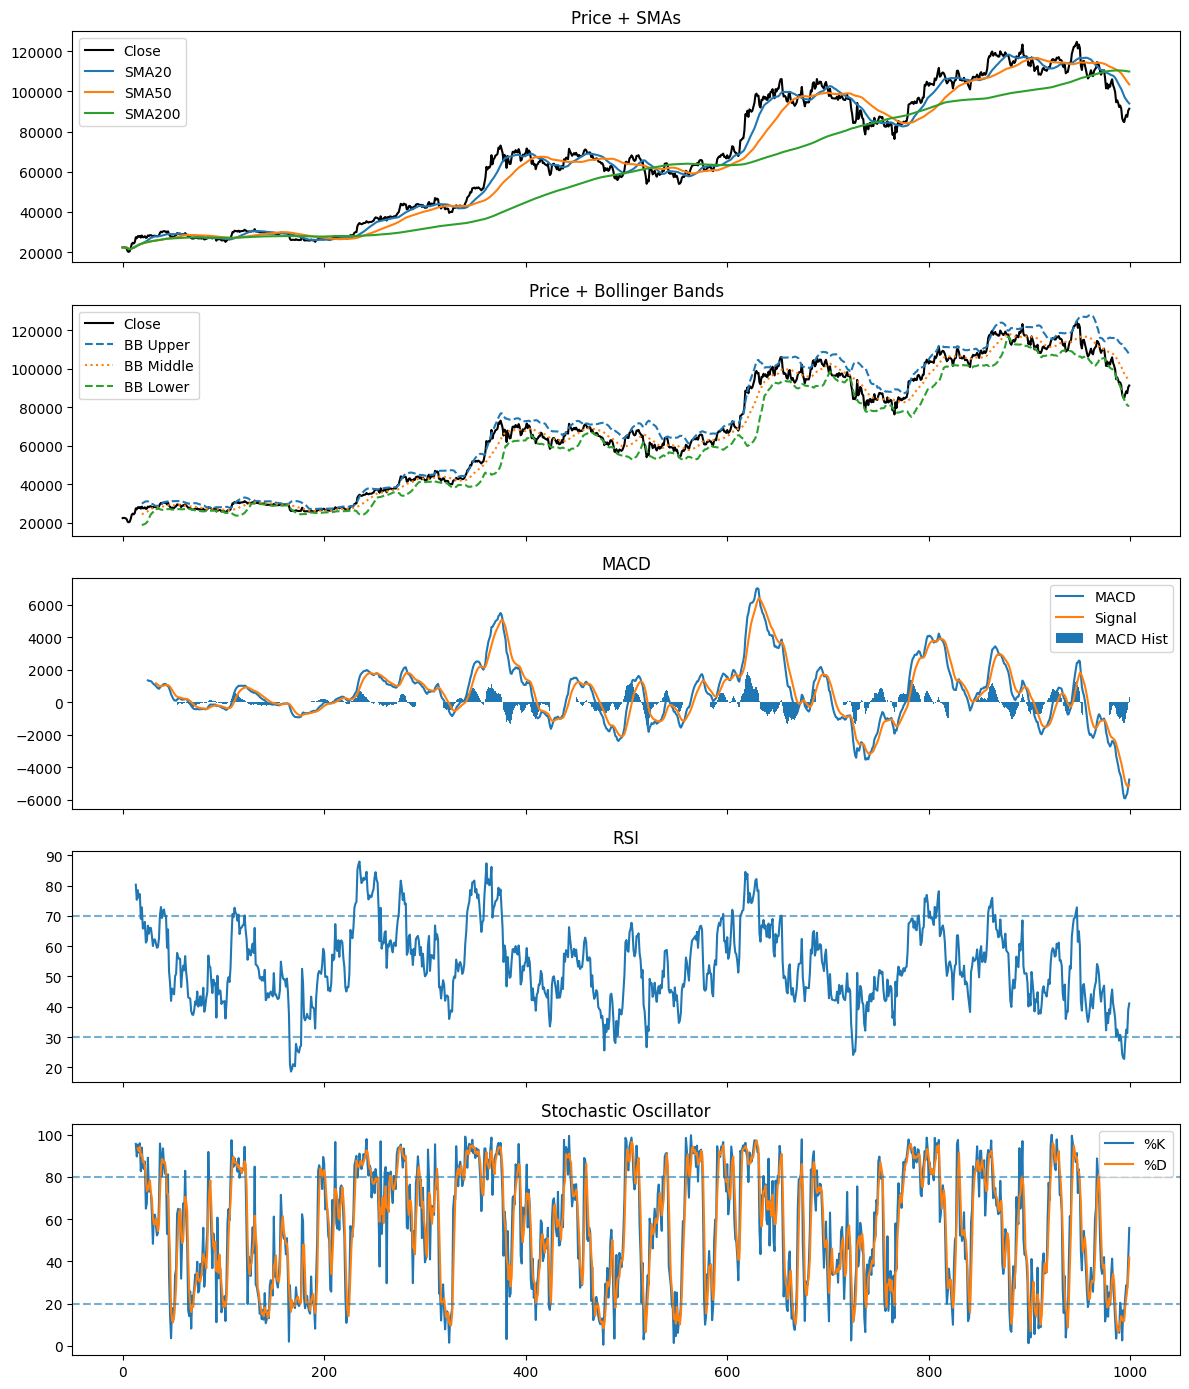

In [8]:

df = data
df_with_ind = compute_indicators(df)
plot_price_with_indicators(df_with_ind)

In [9]:
data=df_with_ind
data


,index,open_time,open,high,low,close,volume,close_time,quote_volume,trades,...,bb_pct,stoch_k,stoch_d,sma_20_above_50,macd_above_signal,rsi_overbought,rsi_oversold,bb_break_upper,bb_break_lower,bb_mid_cross
0,0,2023-03-04,22354.34,22410.00,22157.08,22346.57,121257.38132,2023-03-04 23:59:59.999,2706422995.68025610,4169260,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,1,2023-03-05,22346.57,22662.09,22189.22,22430.24,154841.75786,2023-03-05 23:59:59.999,3473011455.18795160,4835978,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,2,2023-03-06,22430.24,22602.19,22258.00,22410.00,203751.82957,2023-03-06 23:59:59.999,4569102169.18569090,6471278,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,3,2023-03-07,22409.41,22557.91,21927.00,22197.96,292519.80912,2023-03-07 23:59:59.999,6517594938.24605280,7813394,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,4,2023-03-08,22198.56,22287.00,21580.00,21705.44,301460.57272,2023-03-08 23:59:59.999,6641171704.24242130,8018963,...,NaN,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,2025-11-23,84739.75,88127.64,84667.57,86830.00,19734.46418,2025-11-23 23:59:59.999,1708685030.27986950,5063493,...,0.144482,23.159851,18.462416,0,0,0,1,0,0,0
996,996,2025-11-24,86830.00,89228.00,85272.00,88300.01,24663.12795,2025-11-24 23:59:59.999,2150393686.92031830,6189156,...,0.227157,28.624572,22.391264,0,0,0,0,0,0,0
997,997,2025-11-25,88300.01,88519.99,86116.00,87369.96,19567.04110,2025-11-25 23:59:59.999,1708989000.03893710,4838747,...,0.222974,27.371810,26.385411,0,0,0,0,0,0,0
998,998,2025-11-26,87369.97,90656.08,86306.77,90484.02,21675.82239,2025-11-26 23:59:59.999,1916851896.66996890,4668280,...,0.351991,42.086505,32.694296,0,0,0,0,0,0,0


## Step 4 --- Label Generation (Target Variable)

In [10]:
# Creating target variable
data["future_return"] = data["close"].pct_change().shift(-1)

def label(row):
    if row["future_return"] > 0.02:
        return 2
    elif row["future_return"] < -0.02:
        return 0
    else:
        return 1

data["label"] = data.apply(label, axis=1)

In [11]:
#drop rows with NaN values
data = data.dropna().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               966 non-null    int64         
 1   open_time           966 non-null    datetime64[ns]
 2   open                966 non-null    float64       
 3   high                966 non-null    float64       
 4   low                 966 non-null    float64       
 5   close               966 non-null    float64       
 6   volume              966 non-null    float64       
 7   close_time          966 non-null    datetime64[ns]
 8   quote_volume        966 non-null    object        
 9   trades              966 non-null    int64         
 10  taker_base          966 non-null    object        
 11  taker_quote         966 non-null    object        
 12  ignore              966 non-null    object        
 13  1d_return           966 non-null    float64       

## Step 5 --- Train/Test Split

In [26]:
X=data.drop(columns=["label","index","close_time","open_time","quote_volume","taker_base","trades","taker_quote"],axis=1)
y=data["label"]

In [27]:
X

,open,high,low,close,volume,ignore,1d_return,7d_return,rolling_volatility,sma_20,...,stoch_k,stoch_d,sma_20_above_50,macd_above_signal,rsi_overbought,rsi_oversold,bb_break_upper,bb_break_lower,bb_mid_cross,future_return
0,28170.01,28182.05,27711.00,28033.82,40118.94963,0,-0.004835,0.000189,0.686449,27857.8530,...,57.001950,60.337600,1,0,0,0,0,0,0,-0.004548
1,28033.83,28100.00,27766.94,27906.33,24762.09387,0,-0.004548,-0.019639,0.679270,27907.7950,...,52.238711,57.110299,1,0,0,0,0,0,0,0.001148
2,27906.34,28154.99,27859.02,27938.38,19479.96735,0,0.001148,-0.018077,0.630291,27906.0705,...,53.436153,54.225605,1,0,0,0,0,0,1,0.013794
3,27938.38,28530.00,27800.00,28323.76,32531.16101,0,0.013794,0.005392,0.625537,27936.4080,...,67.834592,57.836485,1,0,0,0,0,0,0,0.046377
4,28323.76,29770.00,28170.00,29637.34,67754.06220,0,0.046377,0.066091,0.636950,28013.0015,...,95.772763,72.347836,1,0,1,0,1,0,0,0.018999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,85129.42,85620.00,83500.00,84739.74,14193.93263,0,-0.004578,-0.113566,0.419307,97589.5980,...,15.389368,11.579273,0,0,0,1,0,0,0,0.024667
962,84739.75,88127.64,84667.57,86830.00,19734.46418,0,0.024667,-0.078839,0.431194,96601.9460,...,23.159851,18.462416,0,0,0,1,0,0,0,0.016930
963,86830.00,89228.00,85272.00,88300.01,24663.12795,0,0.016930,-0.042456,0.437358,95942.0855,...,28.624572,22.391264,0,0,0,0,0,0,0,-0.010533
964,88300.01,88519.99,86116.00,87369.96,19567.04110,0,-0.010533,-0.060142,0.420240,95116.3255,...,27.371810,26.385411,0,0,0,0,0,0,0,0.035642


In [65]:
#splitting timeseries data

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size  
X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]
X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]



In [54]:
#scaling the features
from sklearn.preprocessing import StandardScaler    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)    
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Step 6 --- Model Training

In [57]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression Model
model = LogisticRegression( max_iter=1000)

# Training and Evaluation
model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = model.predict(X_val_scaled)

# Evaluating the model
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[20  2  0]
 [ 0 95  4]
 [ 0  0 23]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.98      0.96      0.97        99
           2       0.85      1.00      0.92        23

    accuracy                           0.96       144
   macro avg       0.94      0.96      0.95       144
weighted avg       0.96      0.96      0.96       144



In [61]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Creating the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train_scaled, y_train)

# Making predictions
y_rf_pred = rf_model.predict(X_val_scaled)

# Evaluating the model
print(confusion_matrix(y_val, y_rf_pred))
print(classification_report(y_val, y_rf_pred))


[[22  0  0]
 [ 6 93  0]
 [ 0  0 23]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        22
           1       1.00      0.94      0.97        99
           2       1.00      1.00      1.00        23

    accuracy                           0.96       144
   macro avg       0.93      0.98      0.95       144
weighted avg       0.97      0.96      0.96       144



In [60]:
#lightgbm
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_val = lgb.Dataset(X_val_scaled, y_val, reference=lgb_train)
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
# Training the model
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val])

# Making predictions
y_lgb_pred = lgb_model.predict(X_val_scaled)
y_lgb_pred_classes = np.argmax(y_lgb_pred, axis=1)

# Evaluating the model
print(confusion_matrix(y_val, y_lgb_pred_classes))
print(classification_report(y_val, y_lgb_pred_classes))


[[21  1  0]
 [ 0 99  0]
 [ 0  0 23]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.99      1.00      0.99        99
           2       1.00      1.00      1.00        23

    accuracy                           0.99       144
   macro avg       1.00      0.98      0.99       144
weighted avg       0.99      0.99      0.99       144



In [62]:
# xgboost
import xgboost as xgb

# Creating the model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)

# Training the model
xgb_model.fit(X_train_scaled, y_train)

# Making predictions
y_xgb_pred = xgb_model.predict(X_val_scaled)

# Evaluating the model
print(confusion_matrix(y_val, y_xgb_pred))
print(classification_report(y_val, y_xgb_pred))


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:199: UserWarning: [02:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[22  0  0]
 [ 0 99  0]
 [ 0  0 23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        23

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144



In [64]:
# catboost
from catboost import CatBoostClassifier 

# Creating the model
cat_model = CatBoostClassifier(loss_function='MultiClass', verbose=0)

# Training the model
cat_model.fit(X_train_scaled, y_train)

# Making predictions
y_cat_pred = cat_model.predict(X_val_scaled)

# Evaluating the model
print(confusion_matrix(y_val, y_cat_pred))
print(classification_report(y_val, y_cat_pred))

[[22  0  0]
 [ 0 99  0]
 [ 0  0 23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        23

    accuracy                           1.00       144
   macro avg       1.00      1.00      1.00       144
weighted avg       1.00      1.00      1.00       144

